In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import json
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input as effnet_preprocess
import seaborn as sns
import pandas as pd

In [3]:
# -----------------------------
# PARAMETERS
# -----------------------------
TRAIN_DIR = r"E:\FYP\chest_xray\train"
VAL_DIR = r"E:\FYP\chest_xray\val"      # if you have separate val folder
TEST_DIR = r"E:\FYP\chest_xray\test"
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
SEED = 42
EPOCHS = 10
MODEL_OUT = "lung_disease_classifier.keras"
USE_VAL_DIR = True  # set False if using validation split from train

In [6]:
# -----------------------------
# DATA GENERATORS
# -----------------------------
train_aug = ImageDataGenerator(
    preprocessing_function=effnet_preprocess,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)
val_aug = ImageDataGenerator(preprocessing_function=effnet_preprocess)
test_aug = ImageDataGenerator(preprocessing_function=effnet_preprocess)

if USE_VAL_DIR:
    train_gen = train_aug.flow_from_directory(
        TRAIN_DIR,
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode="binary",
        shuffle=True,
        seed=SEED
    )
    val_gen = val_aug.flow_from_directory(
        VAL_DIR,
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode="binary",
        shuffle=False,
        seed=SEED
    )
else:
    train_gen = train_aug.flow_from_directory(
        TRAIN_DIR,
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode="binary",
        shuffle=True,
        seed=SEED
    )
    val_gen = None

test_gen = test_aug.flow_from_directory(
    TEST_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary",
    shuffle=False,
    seed=SEED
)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [8]:
# -----------------------------
# MODEL
# -----------------------------
base_model = EfficientNetB0(include_top=False, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3), weights="imagenet")
base_model.trainable = False  # freeze base for transfer learning

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation="relu")(x)
outputs = Dense(1, activation="sigmoid")(x)  # binary classification

model = Model(inputs=base_model.input, outputs=outputs)
model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)    │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ rescaling_2 (Rescaling)       │ (None, 224, 224, 3)       │               0 │ input_layer_1[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ normalization_1               │ (None, 224, 224, 3)       │               7 │ rescaling_2[0][0]          │
│ (Normalization)               │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ rescaling_3 (Rescaling)       │ (None, 224, 224, 3)       │               0 │ normalization_1[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_conv_pad (ZeroPadding2D) │ (None, 225, 225, 3)       │               0 │ rescaling_3[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_conv (Conv2D)            │ (None, 112, 112, 32)      │             864 │ stem_conv_pad[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_bn (BatchNormalization)  │ (None, 112, 112, 32)      │             128 │ stem_conv[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_activation (Activation)  │ (None, 112, 112, 32)      │               0 │ stem_bn[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_dwconv                │ (None, 112, 112, 32)      │             288 │ stem_activation[0][0]      │
│ (DepthwiseConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_bn                    │ (None, 112, 112, 32)      │             128 │ block1a_dwconv[0][0]       │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_activation            │ (None, 112, 112, 32)      │               0 │ block1a_bn[0][0]           │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_squeeze            │ (None, 32)                │               0 │ block1a_activation[0][0]   │
│ (GlobalAveragePooling2D)      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_reshape (Reshape)  │ (None, 1, 1, 32)          │               0 │ block1a_se_squeeze[0][0]   │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_reduce (Conv2D)    │ (None, 1, 1, 8)           │             264 │ block1a_se_reshape[0][0]   │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_expand (Conv2D)    │ (None, 1, 1, 32)          │             28

 Total params: 4,213,668 (16.07 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [9]:
# -----------------------------
# CALLBACKS
# -----------------------------
checkpoint = ModelCheckpoint(MODEL_OUT, monitor="val_loss", save_best_only=True, verbose=1)
early_stop = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

In [10]:
# -----------------------------
# TRAINING
# -----------------------------
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    callbacks=[checkpoint, early_stop]
)

C:\Users\shehr\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10

Epoch 1: val_loss improved from inf to 0.10579, saving model to lung_disease_classifier.keras
163/163 ━━━━━━━━━━━━━━━━━━━━ 345s 2s/step - accuracy: 0.9024 - loss: 0.2212 - val_accuracy: 1.0000 - val_loss: 0.1058
Epoch 2/10

Epoch 2: val_loss improved from 0.10579 to 0.10015, saving model to lung_disease_classifier.keras
163/163 ━━━━━━━━━━━━━━━━━━━━ 276s 2s/step - accuracy: 0.9560 - loss: 0.1162 - val_accuracy: 1.0000 - val_loss: 0.1002
Epoch 3/10

Epoch 3: val_loss did not improve from 0.10015
163/163 ━━━━━━━━━━━━━━━━━━━━ 288s 2s/step - accuracy: 0.9555 - loss: 0.1125 - val_accuracy: 0.9375 - val_loss: 0.1412
Epoch 4/10

Epoch 4: val_loss improved from 0.10015 to 0.08025, saving model to lung_disease_classifier.keras
163/163 ━━━━━━━━━━━━━━━━━━━━ 274s 2s/step - accuracy: 0.9577 - loss: 0.1108 - val_accuracy: 1.0000 - val_loss: 0.0802
Epoch 5/10

Epoch 5: val_loss did not improve from 0.08025
163/163 ━━━━━━━━━━━━━━━━━━━━ 264s 2s/step - accuracy: 0.9655 - loss: 0.0885 - val_ac

In [11]:
# -----------------------------
# SAVE LABELS
# -----------------------------
labels = train_gen.class_indices
with open("labels.json", "w") as f:
    json.dump(labels, f)

In [12]:
# -----------------------------
# EVALUATION
# -----------------------------
preds = model.predict(test_gen, verbose=1)
pred_labels = (preds > 0.5).astype(int)

true_labels = test_gen.classes
report = classification_report(true_labels, pred_labels, target_names=list(labels.keys()))
conf_matrix = confusion_matrix(true_labels, pred_labels)

with open("classification_report.json", "w") as f:
    json.dump({"report": report, "confusion_matrix": conf_matrix.tolist()}, f)

print(report)
print("Confusion Matrix:\n", conf_matrix)


20/20 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step 
              precision    recall  f1-score   support

      NORMAL       0.95      0.70      0.81       234
   PNEUMONIA       0.84      0.98      0.91       390

    accuracy                           0.87       624
   macro avg       0.90      0.84      0.86       624
weighted avg       0.88      0.87      0.87       624

Confusion Matrix:
 [[164  70]
 [  9 381]]


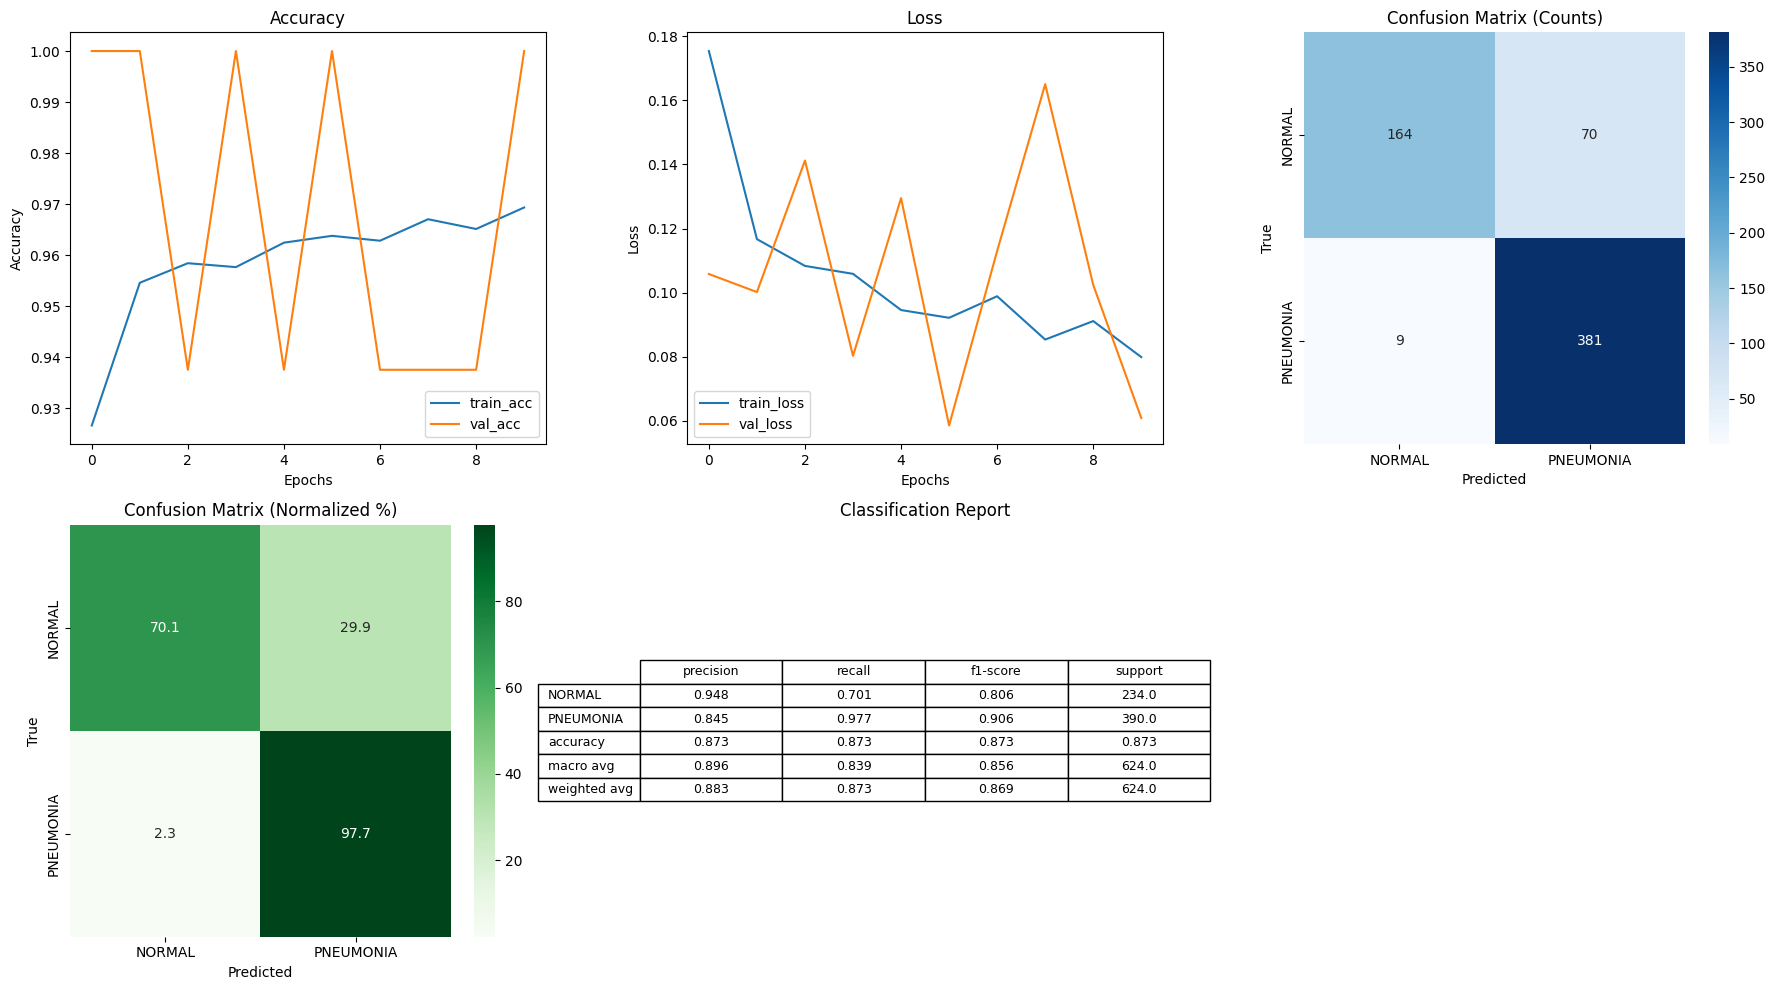

In [16]:
# -----------------------------
# VISUALIZATION DASHBOARD (2x3 Grid)
# -----------------------------
# Convert classification report to DataFrame
report_dict = classification_report(true_labels, pred_labels, target_names=list(labels.keys()), output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Accuracy
axes[0,0].plot(history.history["accuracy"], label="train_acc")
axes[0,0].plot(history.history["val_accuracy"], label="val_acc")
axes[0,0].set_title("Accuracy")
axes[0,0].set_xlabel("Epochs")
axes[0,0].set_ylabel("Accuracy")
axes[0,0].legend()

# Loss
axes[0,1].plot(history.history["loss"], label="train_loss")
axes[0,1].plot(history.history["val_loss"], label="val_loss")
axes[0,1].set_title("Loss")
axes[0,1].set_xlabel("Epochs")
axes[0,1].set_ylabel("Loss")
axes[0,1].legend()

# Raw Confusion Matrix
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=list(labels.keys()), yticklabels=list(labels.keys()),
            ax=axes[0,2])
axes[0,2].set_title("Confusion Matrix (Counts)")
axes[0,2].set_xlabel("Predicted")
axes[0,2].set_ylabel("True")

# Normalized Confusion Matrix (%)
conf_matrix_norm = conf_matrix.astype("float") / conf_matrix.sum(axis=1)[:, np.newaxis]
sns.heatmap(conf_matrix_norm * 100, annot=True, fmt=".1f", cmap="Greens",
            xticklabels=list(labels.keys()), yticklabels=list(labels.keys()),
            ax=axes[1,0])
axes[1,0].set_title("Confusion Matrix (Normalized %)")
axes[1,0].set_xlabel("Predicted")
axes[1,0].set_ylabel("True")

# Classification Report Table
axes[1,1].axis("tight")
axes[1,1].axis("off")
table = axes[1,1].table(cellText=np.round(report_df.values, 3),
                        colLabels=report_df.columns,
                        rowLabels=report_df.index,
                        cellLoc="center", loc="center")
table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1.2, 1.2)
axes[1,1].set_title("Classification Report")

# Empty Panel
axes[1,2].axis("off")

plt.tight_layout()
plt.show()